<a href="https://colab.research.google.com/github/ashwindasr/Diabetic-Retinopathy/blob/master/diabetic_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import numpy as np
import cv2

In [0]:
# Import the necessary FastAi modules
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy, error_rate

In [0]:
# Create two directories to store the images after applying CLAHE
os.mkdir("../train_images")
os.mkdir("../test_images")

In [0]:
# Load the images 
for x in os.listdir("../input/aptos2019-blindness-detection/train_images/"):
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/"+x,0)
    equ = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(equ)
    cv2.imwrite("../train_images/"+x,cl1)
#  Apply CLAHE method for preprocessing 
for x in os.listdir("../input/aptos2019-blindness-detection/test_images/"):
    img = cv2.imread("../input/aptos2019-blindness-detection/test_images/"+x,0)
    equ = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(equ)
    cv2.imwrite("../test_images/"+x,cl1)

In [0]:
test_df = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
test_img = ImageList.from_df(test_df, path="..", folder='/test_images',suffix='.png')

train_df = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
tfms = get_transforms(do_flip=False)

In [0]:
# Set the seed and load the data.
np.random.seed(5)
data = (ImageList.from_df(train_df,path="..",folder="/train_images",suffix='.png')
        .split_by_rand_pct()
        .label_from_df(cols='diagnosis')
        .add_test(test_img)
        .transform(tfms,size = 256)
        .databunch(bs=64)    
        .normalize(imagenet_stats)
       )
# Check out the FastAI docs to see the diffrent ways to load your data.

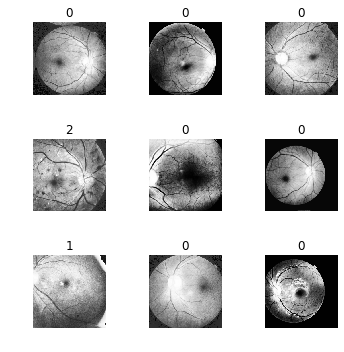

In [0]:
# Display a few images to make sure the data is loaded and preprocessed correctly
data.show_batch(rows=3,figsize = (5,5))

In [0]:
# To list out the number of classes
data.valid_ds.classes

[0, 1, 2, 3, 4]

In [0]:
# Load the resnet weights
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp ../input/resnet50/resnet50.pth /tmp/.cache/torch/checkpoints/resnet50.pth
!mv  /tmp/.cache/torch/checkpoints/resnet50.pth /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
# This is unique to Kaggle Kernels. You can skip this step.

In [0]:
# Load and initialize the model. We use Resnet50 as the pretrained model.
model = cnn_learner(data,models.resnet50, metrics = [accuracy,error_rate],callback_fns=ShowGraph)

In [0]:
model.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
___________________________________________________

In [0]:
# model.model_dir = '../kaggle/working/models/'

In [0]:
# FastAI plots the ranges of learning rate values we can use.
model.lr_find()
model.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.868984,1.178690,0.670765,0.329235,05:31
1,0.704675,0.699472,0.750000,0.250000,05:24
2,0.626374,0.652191,0.739071,0.260929,05:22
3,0.549581,0.468654,0.815574,0.184426,05:23
4,0.483099,0.444356,0.830601,0.169399,05:20


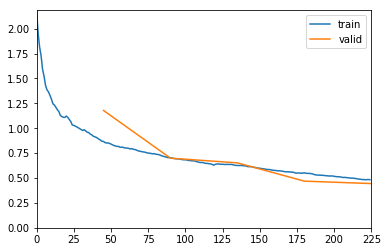

In [0]:
# Train only the last layer while the other layers are frozen.
model.fit_one_cycle(5,1e-2)

In [0]:
# Unfreeze all the layers and plot the learning rate
model.unfreeze()
model.lr_find()
model.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.436950,0.448386,0.836066,0.163934,05:20
1,0.440953,0.450072,0.830601,0.169399,05:21
2,0.417661,0.448884,0.834699,0.165301,05:19
3,0.409925,0.448478,0.831967,0.168033,05:22
4,0.395139,0.458012,0.826503,0.173497,05:18
5,0.377323,0.458865,0.831967,0.168033,05:18
6,0.360947,0.470731,0.829235,0.170765,05:22
7,0.346042,0.463800,0.829235,0.170765,05:20
8,0.352129,0.459166,0.829235,0.170765,05:24
9,0.334282,0.455031,0.830601,0.169399,05:20


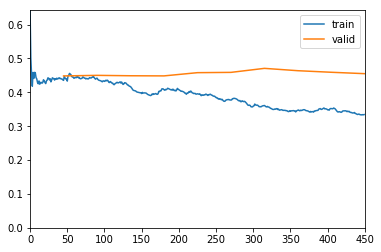

In [0]:
# Train through all the layers
model.fit_one_cycle(10,max_lr = slice(1e-6,1e-4))

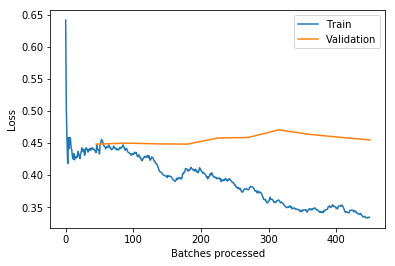

In [0]:
# Plot the losses
model.recorder.plot_losses()

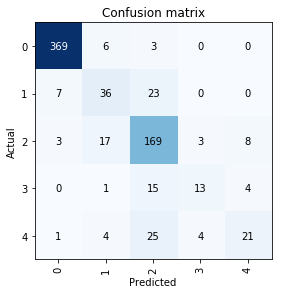

In [0]:
# Check how many cases the model cassified correctly
interpreter = ClassificationInterpretation.from_learner(model)
interpreter.plot_confusion_matrix()

In [0]:
# Generate the predictions for the test set
preds, _ = model.get_preds(ds_type=DatasetType.Test)

In [0]:
test_df["diagnosis"] = preds.argmax(1)

In [0]:
test_df.to_csv('submission.csv', index=False)